In [5]:
!nvidia-smi

Fri Aug 20 05:50:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib as plt
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json, pickle
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from bs4 import BeautifulSoup
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,GRU,Bidirectional
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
import re
from re import sub
import multiprocessing
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling1D, Conv1D, MaxPooling1D
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

# **Dataset without stop word**

In [8]:
file="/content/drive/MyDrive/stop_news.csv"
dataset=pd.read_csv(file,error_bad_lines=False, engine="python" ) # engine ="c" 
print(f"There are {len(dataset)} articles in the dataset.")

There are 28800 articles in the dataset.


# **Dataset summary**

# **Label Encoding, Tokenization & Padding**

In [9]:
from sklearn.preprocessing import LabelEncoder

catlabel = LabelEncoder()
label = catlabel.fit_transform(dataset['category'])


print(set(label))
print(catlabel.classes_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
['accident' 'art' 'crime' 'economics' 'education' 'entertainment'
 'environment' 'international' 'opinion' 'politics' 'science_tech'
 'sports']


# **Train & split**

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(dataset['news'])

In [11]:
len(tokenizer.word_index)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

297130

In [12]:
max_length = 350
trunc_type='post'
padding_type='post'
news = dataset['news']
news_sequences = tokenizer.texts_to_sequences(news)
news_padded = pad_sequences(news_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# **Fasttext Word Embedding**

In [13]:
from urllib.request import urlopen
import gzip
file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz'))

In [14]:
vocab_and_vectors = {}
for line in file:
  values = line.split()
  word = values[0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float16')
  vocab_and_vectors[word] = vector

In [15]:
len(vocab_and_vectors)

1468579

In [16]:
max_nb_features = 297131
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(max_nb_features, vocab_size)
embedding_matrix = np.zeros((nb_words,300))
for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = vocab_and_vectors.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 123681


In [17]:
len(embedding_matrix)
nb_words

297130

In [18]:
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling1D, Conv1D, MaxPooling1D, GlobalMaxPool1D

# **Model**

In [19]:
model= Sequential()
model.add(Embedding(nb_words, 300, weights=[embedding_matrix], input_length=max_length))
#model.add(Conv1D(512, 3, activation= 'elu'))
model.add(Bidirectional(LSTM(256, return_sequences=True,dropout = 0.3)))
model.add(Bidirectional(LSTM(256, return_sequences=True,dropout = 0.3)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Flatten())
model.add(Dense(12 , activation='softplus'))

model.summary()

model.compile(optimizer='adamax',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 350, 300)          89139000  
_________________________________________________________________
bidirectional (Bidirectional (None, 350, 512)          1140736   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 350, 512)          1574912   
_________________________________________________________________
dense (Dense)                (None, 350, 128)          65664     
_________________________________________________________________
dense_1 (Dense)              (None, 350, 128)          16512     
_________________________________________________________________
flatten (Flatten)            (None, 44800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                5

In [20]:
X,X_test,y,y_test = train_test_split(news_padded,label,train_size = 0.8,
                                                  test_size = 0.2,random_state =42)
X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =42)

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_valid.shape)
print(y_valid.shape)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_valid = np.asarray(X_valid)
y_valid = np.asarray(y_valid)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

(18432, 350)
(18432,)
(5760, 350)
(5760,)
(4608, 350)
(4608,)


In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath="/content/drive/MyDrive/Model/20.h5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
checkpointer = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=128, y=y_train, verbose=1, validation_data=(X_valid,y_valid), 
          shuffle=True, epochs=95, callbacks=[es, checkpointer])

Epoch 1/95
144/144 [==============================] - 57s 319ms/step - loss: 0.9060 - accuracy: 0.7022 - val_loss: 0.4843 - val_accuracy: 0.8451

Epoch 00001: val_accuracy improved from -inf to 0.84505, saving model to /content/drive/MyDrive/Model/20.h5
Epoch 2/95
144/144 [==============================] - 47s 324ms/step - loss: 0.3422 - accuracy: 0.8957 - val_loss: 0.3825 - val_accuracy: 0.8839

Epoch 00002: val_accuracy improved from 0.84505 to 0.88390, saving model to /content/drive/MyDrive/Model/20.h5
Epoch 3/95
144/144 [==============================] - 47s 329ms/step - loss: 0.2011 - accuracy: 0.9360 - val_loss: 0.3399 - val_accuracy: 0.8978

Epoch 00003: val_accuracy improved from 0.88390 to 0.89779, saving model to /content/drive/MyDrive/Model/20.h5
Epoch 4/95
144/144 [==============================] - 48s 333ms/step - loss: 0.1241 - accuracy: 0.9616 - val_loss: 0.3635 - val_accuracy: 0.8984

Epoch 00004: val_accuracy improved from 0.89779 to 0.89844, saving model to /content/d

In [23]:
model=load_model("/content/drive/MyDrive/Model/20.h5")
class_names = ['Accident' ,'Art' ,'Crime', 'Economics' ,'Education' ,'Entertainment',
 'Environment' ,'International' ,'Opinion' ,'Politics', 'Science' ,'Sports']
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'Accident','1':'Art','2':'Crime','3':'Economics','4':'Education','5':'Entertainment',
                              '6': 'Environment','7':'International','8':'Opinion','9':'Politics','10':'Science','11':'Sports'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
Accident,91.68,92.67,92.18,464.000000
Art,87.37,85.04,86.19,488.000000
Crime,89.71,88.44,89.07,493.000000
Economics,88.68,93.90,91.22,459.000000
Education,96.98,95.74,96.36,470.000000
Entertainment,94.77,94.04,94.40,520.000000
Environment,91.22,91.61,91.42,465.000000
International,93.35,91.77,92.55,474.000000
Opinion,89.63,89.44,89.54,464.000000
Politics,91.87,94.56,93.20,478.000000


In [24]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=1)
_, test_acc = model.evaluate(X_valid, y_valid, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

144/144 [==============================] - 6s 43ms/step - loss: 0.5772 - accuracy: 0.9178
Train: 0.999, Test: 0.918


In [25]:
class_names = ['Accident' ,'Art' ,'Crime', 'Economics' ,'Education' ,'Entertainment',
 'Environment' ,'International' ,'Opinion' ,'Politics', 'Science' ,'Sports']
print(classification_report(y_test, y_pred, digits=4, target_names=class_names))

               precision    recall  f1-score   support

     Accident     0.9168    0.9267    0.9218       464
          Art     0.8737    0.8504    0.8619       488
        Crime     0.8971    0.8844    0.8907       493
    Economics     0.8868    0.9390    0.9122       459
    Education     0.9698    0.9574    0.9636       470
Entertainment     0.9477    0.9404    0.9440       520
  Environment     0.9122    0.9161    0.9142       465
International     0.9335    0.9177    0.9255       474
      Opinion     0.8963    0.8944    0.8954       464
     Politics     0.9187    0.9456    0.9320       478
      Science     0.9466    0.9210    0.9336       481
       Sports     0.9429    0.9504    0.9466       504

     accuracy                         0.9203      5760
    macro avg     0.9202    0.9203    0.9201      5760
 weighted avg     0.9205    0.9203    0.9203      5760



In [26]:
print(confusion_matrix(y_test, y_pred))

print('\nbert-Accuracy: {0:.2f}%'.format(accuracy_score(y_test, y_pred)*100))

[[430   2  19   0   0   0  10   0   0   0   1   2]
 [  1 415   1   0   4  10   7   3  24   1   4  18]
 [ 23   0 436   4   0   0   5   2   0  23   0   0]
 [  0   0   3 431   1   1   4   5   2   2   9   1]
 [  0   4   3   2 450   2   0   0   6   1   2   0]
 [  0   9   3   3   2 489   0   6   3   1   2   2]
 [  6   7   3  11   1   1 426   1   5   3   0   1]
 [  4   0   2  11   0   4   3 435   6   7   2   0]
 [  1  22   0   9   1   3   2   5 415   2   2   2]
 [  1   0  16   5   0   0   2   1   1 452   0   0]
 [  1   6   0  10   3   3   5   6   1   0 443   3]
 [  2  10   0   0   2   3   3   2   0   0   3 479]]

bert-Accuracy: 92.03%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


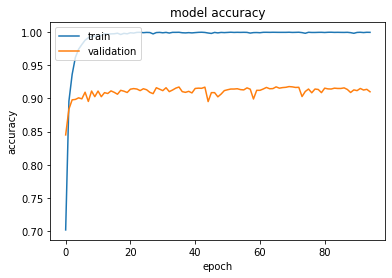

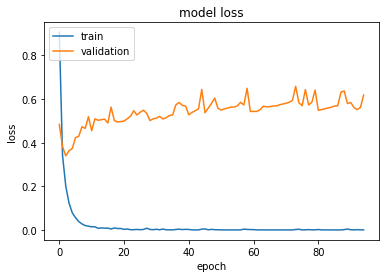

In [27]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

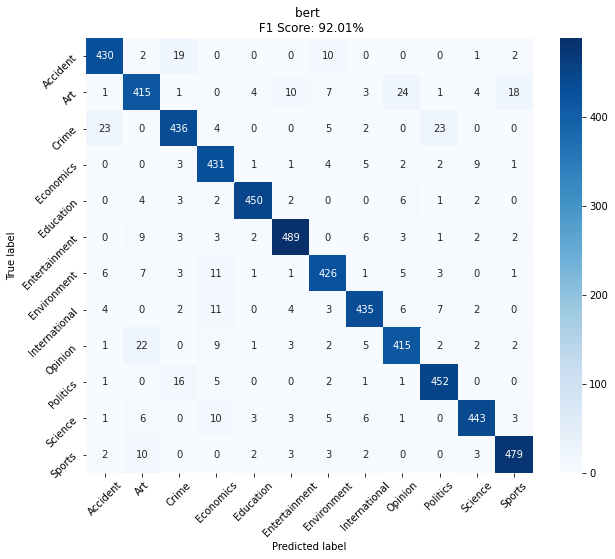

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred) 

class_names = ['Accident' ,'Art' ,'Crime', 'Economics' ,'Education' ,'Entertainment',
 'Environment' ,'International' ,'Opinion' ,'Politics', 'Science' ,'Sports']
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = class_names, 
                     columns = class_names)

plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True,cmap="Blues", fmt='g')
plt.title('bert \n F1 Score: {0:.2f}%'.format(f1_score(y_test, y_pred , average='macro')*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()